In [1]:
import os
import shutil
import warnings

import numpy as np
import pandas as pd
import plotly.graph_objects as go
import torchaudio

warnings.filterwarnings(action="ignore")
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
import json

import geopandas
import librosa
import librosa.display
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import soundfile

import tensorflow as tf
import tensorflow_addons as tfa
import torch

%matplotlib inline
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from torchaudio.transforms import MelSpectrogram
from tqdm import tqdm

from src.MEL_Gen import MEL_Gen, Mel_Provider
from src.prepare_dataset import (
    choose_ids,
    make_dict_birds,
    make_intervals,
    make_intervals_upsampling,
    prepare_dataset,
)

In [2]:
SEED = 78
IMG_SIZE = 260
SAMPLE_RATE = 32000
N_FFT = 2048
SIGNAL_LENGTH = 5
FREQ_MIN = 0
FREQ_MAX = 16000
WIN_LENGHT = 1024
BATCH_SIZE = 300
list_drop = [
    "XC509721.ogg",
    "XC428067.ogg",
    "XC523831.ogg",
    "XC523960.ogg",
    "XC237870.ogg",
    "XC129924.ogg",
    "XC576851.ogg",
    "XC579430.ogg",
    "XC590621.ogg",
]

In [3]:
nocall = pd.read_csv("/app/_data/labels_nocall/all_nocalls.csv")

In [4]:
all_audio = pd.read_csv("/app/_data/all_audio_initial.csv")
all_audio = all_audio.query("filename not in @list_drop").reset_index(drop=True)
all_audio = all_audio.query("year >=1980 and year<=2021").reset_index(drop=True)
all_audio.shape

(65128, 24)

In [5]:
_, list_filenames = choose_ids(1000, start_year=1990)
len(list_filenames)

42727

In [6]:
all_audio = all_audio.query('filename in @list_filenames').reset_index(drop=True)

# dict_birds and weights

In [7]:
all_audio = all_audio[all_audio["rating"] >= 2.5]

In [8]:
all_audio.shape

(41267, 24)

In [9]:
dict_birds, all_audio = make_dict_birds(all_audio)

In [10]:
len(dict_birds)

395

In [11]:
# os.mkdir("/app/_data/models/Eff2_5/")

In [12]:
file_json = open("/app/_data/models/Eff2_5/dict_birds.json", "w")
json.dump(dict_birds, file_json)
file_json.close()

In [13]:
dict_weights = (1 / all_audio["primary_label"].value_counts()).to_dict()
all_audio["class_weights"] = all_audio["primary_label"].replace(dict_weights)
all_audio["class_weights"] = all_audio["class_weights"] * all_audio["rating"]

In [14]:
short_audio = all_audio[all_audio["rating"] != 6].reset_index(
    drop=True
)  # only short audio
train_sondscapes = all_audio[all_audio["rating"] == 6].reset_index(
    drop=True
)  # only train_soundscapes
short_audio.shape
train_sondscapes.shape
train_sondscapes['duration']=600

(38867, 24)

(2400, 24)

## calls

In [15]:
short_audio_0_20 = short_audio[short_audio['duration']<19]
short_audio_20_30 = short_audio[(short_audio['duration']>=19)&(short_audio['duration']<=30)]
short_audio_30 = short_audio[short_audio['duration']>30]

In [16]:
short_audio_20_30['duration'] = short_audio_20_30['duration']-4
short_audio_30['duration'] = short_audio_30['duration']-7

In [17]:
short_audio = pd.concat([short_audio_0_20,short_audio_20_30,short_audio_30], axis=0, ignore_index=True)

In [18]:
short_audio.shape

(38867, 24)

# Make intervals for short audio

In [19]:
array_for_cut = short_audio[["filename", "duration", "class_weights"]].values

birds_intervals = make_intervals(array_for_cut, 5, max_intervals=200, max_lenght=400)
birds_intervals = birds_intervals.sample(frac=1, random_state=SEED)
birds_intervals.shape

(1080511, 3)

In [20]:
birds_intervals["row_id"] = birds_intervals.index
birds_intervals["filename"].value_counts()

XC268464.ogg    200
XC263188.ogg    200
XC256433.ogg    200
XC530996.ogg    200
XC608256.ogg    200
               ... 
XC166035.ogg      4
XC331890.ogg      4
XC337827.ogg      4
XC538963.ogg      4
XC371529.ogg      4
Name: filename, Length: 38867, dtype: int64

In [21]:
dict_w = pd.DataFrame((1/birds_intervals['filename'].value_counts()))
dict_w.columns=['weights']
dict_w['filename'] = dict_w.index

In [22]:
birds_intervals = birds_intervals.merge(dict_w, on='filename', how='left')

In [23]:
birds_intervals_sample = birds_intervals.sample(
    n=700000, weights="weights", random_state=SEED
)

In [24]:
birds_intervals_sample = birds_intervals_sample.sample(
    n=500000, weights="class_weights", random_state=SEED
)

In [25]:
birds_intervals_sample[birds_intervals_sample['filename']=='XC196037.ogg']

,end_sec,class_weights,filename,row_id,weights
320016,13.0,0.009761,XC196037.ogg,XC196037_13_0,0.1
507790,11.0,0.009761,XC196037.ogg,XC196037_11_0,0.1
573385,14.0,0.009761,XC196037.ogg,XC196037_14_0,0.1


In [26]:
short_audio = birds_intervals_sample.merge(
    short_audio[
        [
            "filename",
            "primary_label",
            "secondary_labels",
            "label_id",
            "secondary_labels_id",
            "duration",
            "rating",
            "year",
            "file_path",
            "frames",
            "sin_month",
            "cos_month",
            "sin_longitude",
            "cos_longitude",
            "latitude",
            "norm_latitude",
            "date",
        ]
    ],
    on="filename",
    how="left",
)

short_audio["filename"].value_counts()

short_audio["end_sec"] = short_audio["end_sec"].apply(lambda x: x if x > 5 else 5)

short_audio["start_sec"] = short_audio["end_sec"] - 5

XC132146.ogg    50
XC323359.ogg    49
XC278263.ogg    49
XC270173.ogg    49
XC392250.ogg    48
                ..
XC612149.ogg     1
XC24161.ogg      1
XC592148.ogg     1
XC31148.ogg      1
XC355258.ogg     1
Name: filename, Length: 38830, dtype: int64

In [27]:
short_audio["primary_label"].value_counts()

cubthr     3192
bncfly     3106
normoc     2999
houwre     2979
spotow     2906
           ... 
banswa       97
wegspa1      86
gbbgul       80
stvhum2      59
mutswa       10
Name: primary_label, Length: 394, dtype: int64

# nocall

In [28]:
nocall = nocall.drop_duplicates()

nocall["file_path"] = nocall["file_path"].str.replace("birdclef-2021/", "")

nocall = nocall[~nocall['file_path'].str.contains('train_soundscapes')].reset_index(drop=True)

soundscapes_nocall =all_audio[all_audio['file_path'].str.contains('train_soundscapes')]
soundscapes_nocall = soundscapes_nocall[soundscapes_nocall['primary_label']=='nocall']

dict_w = (1/nocall['filename'].value_counts()).to_dict()
nocall['weights'] = nocall['filename'].replace(dict_w)

nocall_sample = nocall.sample(1200, random_state=SEED,  weights='weights')

nocall_sample['filename'].value_counts()

XC117324.ogg    15
XC293291.ogg    14
XC317112.ogg    14
XC612864.ogg    12
XC493544.ogg    12
                ..
XC210768.ogg     1
XC564545.ogg     1
XC144370.ogg     1
XC259210.ogg     1
XC187408.ogg     1
Name: filename, Length: 192, dtype: int64

In [29]:
nocall_sample = nocall_sample.merge(
    all_audio[
        [
            "filename",
            "rating",
            "year",
            "sin_month",
            "cos_month",
            "sin_longitude",
            "cos_longitude",
            "latitude",
            "norm_latitude",
            'class_weights'
        ]
    ],
    on="filename",
    how="left",
)

nocall_sample = nocall_sample[['filename', 'row_id', 'start_sec', 'end_sec', 'file_path',
       'duration', 'rating', 'year', 'sin_month', 'cos_month',
       'sin_longitude', 'cos_longitude', 'latitude', 'norm_latitude',
       'class_weights']]
soundscapes_nocall = soundscapes_nocall[['filename', 'row_id', 'start_sec', 'end_sec', 'file_path',
       'duration', 'rating', 'year', 'sin_month', 'cos_month',
       'sin_longitude', 'cos_longitude', 'latitude', 'norm_latitude',
       'class_weights']]

soundscapes_nocall['duration']=600

all_nocall = pd.concat([nocall_sample, soundscapes_nocall], axis=0, ignore_index=True)

all_nocall["label_id"] = dict_birds["nocall"]
all_nocall = all_nocall.sample(frac=1, random_state=SEED).reset_index(drop=True)

all_nocall.isna().sum()
all_nocall = all_nocall.dropna(axis=0)
all_nocall["secondary_labels_id"] = np.nan
all_nocall['year'].describe()

filename           0
row_id             0
start_sec          0
end_sec            0
file_path          0
duration           0
rating           278
year             278
sin_month        278
cos_month        278
sin_longitude    278
cos_longitude    278
latitude         278
norm_latitude    278
class_weights    278
label_id           0
dtype: int64

count    2451.000000
mean     2016.253366
std         4.572663
min      1990.000000
25%      2016.000000
50%      2017.000000
75%      2019.000000
max      2021.000000
Name: year, dtype: float64

# concat

In [30]:
final_audio = (
    pd.concat(
        [short_audio, all_nocall],
        axis=0,
        ignore_index=True,
    )
    .sample(frac=1, random_state=SEED)
    .reset_index(drop=True)
)
final_audio.shape

(502451, 22)

In [31]:
final_audio["primary_label"].value_counts().tail(30)

yelgro     320
grhcha1    317
tunswa     311
lobdow     308
flrtan1    308
orfpar     302
rebsap     300
tropew1    298
baleag     298
rugdov     292
bkbplo     290
commer     282
rubrob     279
buwtea     253
whimbr     238
gwfgoo     227
norsho     207
hofwoo1    207
lotduc     156
comgol     132
sander     129
crfpar     119
rudtur     118
whcpar     105
runwre1    101
banswa      97
wegspa1     86
gbbgul      80
stvhum2     59
mutswa      10
Name: primary_label, dtype: int64

#  upsampling


In [32]:
rare_birds = list(final_audio["primary_label"].value_counts().tail(30).index.values)

In [33]:
df = pd.DataFrame(columns=["end_sec", "class_weights", "filename"])
for bird in rare_birds:
    rare_bird_filenames = (
    all_audio.query("primary_label ==@bird")["filename"].unique().tolist())
    rare_array = all_audio.query(
        "primary_label ==@bird and rating!=0 and rating!=6 and filename in @rare_bird_filenames"
    )[["filename", "duration", "class_weights"]].values
    intervals = make_intervals_upsampling(rare_array,sum_intervals=600)
    df = pd.concat([df, intervals], axis=0)

df

,end_sec,class_weights,filename
XC31693_5_0,5.00,0.3,XC31693.ogg
XC31693_7_09,7.09,0.3,XC31693.ogg
XC31693_9_19,9.19,0.3,XC31693.ogg
XC31693_11_29,11.29,0.3,XC31693.ogg
XC31693_13_39,13.39,0.3,XC31693.ogg
...,...,...,...
XC310077_14_37,14.37,4.0,XC310077.ogg
XC310077_14_38,14.38,4.0,XC310077.ogg
XC310077_14_39,14.39,4.0,XC310077.ogg
XC310077_14_4,14.40,4.0,XC310077.ogg


In [34]:
df['filename'].unique().shape

(421,)

In [35]:
df["row_id"] = df.index
df = df.merge(
    all_audio[
        [
            "filename",
            "primary_label",
            "secondary_labels",
            "label_id",
            "secondary_labels_id",
            "duration",
            "rating",
            "year",
            "file_path",
            "frames",
            "sin_month",
            "cos_month",
            "sin_longitude",
            "cos_longitude",
            "latitude",
            "norm_latitude",
            "date",
        ]
    ],
    on="filename",
    how="left",
)
df["end_sec"] = df["end_sec"].apply(lambda x: x if x > 5 else 5)
df["start_sec"] = df["end_sec"] - 5

In [36]:
df['primary_label'].unique().shape

(30,)

In [37]:
final_audio = (
    pd.concat(
        [final_audio, df],
        axis=0,
        ignore_index=True,
    )
    .sample(frac=1, random_state=SEED)
    .reset_index(drop=True)
)
final_audio.shape

final_audio["primary_label"].value_counts().tail(20)

(521934, 22)

sinwre1    479
gretin1    474
leasan     471
grnher     457
palwar     454
gadwal     453
scrtan1    427
cacgoo1    427
rehbar1    423
bcnher     417
greegr     387
nrwswa     378
categr     373
amewig     365
rthhum     363
rotbec     353
laugul     350
ameavo     350
solsan     333
oliwoo1    322
Name: primary_label, dtype: int64

In [38]:
train, valid = train_test_split(final_audio, train_size=0.8, random_state=SEED)
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)

In [39]:
train[train['duration']>500]

,end_sec,class_weights,filename,row_id,weights,primary_label,secondary_labels,label_id,secondary_labels_id,duration,...,file_path,frames,sin_month,cos_month,sin_longitude,cos_longitude,latitude,norm_latitude,date,start_sec
92,165.00,0.003924,20152_SSW_20170805.ogg,20152_SSW_165,NaN,NaN,NaN,217,NaN,600.000000,...,/app/_data/train_soundscapes/20152_SSW_2017080...,NaN,-0.866025,-0.500000,-0.972166,0.234294,42.4700,0.735944,NaN,160.00
224,74.34,0.022959,XC268850.ogg,XC268850_74_34,0.005025,ducfly,whwdov bncfly astfly spotow bewwre,123,369 49 14 316 32,501.539875,...,/app/_data/train_short_audio/ducfly/XC268850.ogg,16273276.0,0.500000,-0.866025,-0.944638,-0.328113,31.9060,0.677256,2015-05-28,69.34
314,49.52,0.022959,XC268850.ogg,XC268850_49_52,0.005025,ducfly,whwdov bncfly astfly spotow bewwre,123,369 49 14 316 32,501.539875,...,/app/_data/train_short_audio/ducfly/XC268850.ogg,16273276.0,0.500000,-0.866025,-0.944638,-0.328113,31.9060,0.677256,2015-05-28,44.52
339,121.87,0.019231,XC269452.ogg,XC269452_121_87,0.005000,eawpew,norcar comyel dowwoo carwre norfli indbun eastow,130,218 113 122 83 219 180 129,544.677000,...,/app/_data/train_short_audio/eawpew/XC269452.ogg,17653664.0,-0.500000,-0.866025,-0.974242,0.225505,34.7672,0.693151,2015-07-08,116.87
366,153.24,0.037190,XC322595.ogg,XC322595_153_24,0.005025,pinsis,cacwre ducfly whwdov gamqua houfin chispa batp...,246,77 123 369 139 175 95 24 218 14 114 187,538.372531,...,/app/_data/train_short_audio/pinsis/XC322595.ogg,17451921.0,0.866025,-0.500000,-0.944638,-0.328113,31.9060,0.677256,2015-04-27,148.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417064,506.73,0.022843,XC263260.ogg,XC263260_506_73,0.005000,bulori,cacwre caskin whwdov moudov cubthr houfin acow...,71,77 85 369 211 120 175 1 49 139,587.143156,...,/app/_data/train_short_audio/bulori/XC263260.ogg,19012581.0,-0.500000,-0.866025,-0.944638,-0.328113,31.9060,0.677256,2014-07-21,501.73
417153,180.00,0.003924,50878_COR_20191004.ogg,50878_COR_180,NaN,NaN,NaN,217,NaN,600.000000,...,/app/_data/train_soundscapes/50878_COR_2019100...,NaN,-0.866025,0.500000,-0.995413,0.095672,10.1200,0.556222,NaN,175.00
417237,103.23,0.019565,XC608252.ogg,XC608252_103_23,0.005000,normoc,normoc moudov verdin cacwre,220,220 211 345 77,635.277000,...,/app/_data/train_short_audio/normoc/XC608252.ogg,20552864.0,0.500000,-0.866025,-0.944531,-0.328422,31.9570,0.677539,2020-05-01,98.23
417248,360.00,0.003924,31928_COR_20191004.ogg,31928_COR_360,NaN,NaN,NaN,217,NaN,600.000000,...,/app/_data/train_soundscapes/31928_COR_2019100...,NaN,-0.866025,0.500000,-0.995413,0.095672,10.1200,0.556222,NaN,355.00


# MEL_Gen

In [40]:
NUM_CLASSES = len(dict_birds)
BATCH_SIZE = 200

In [41]:
mel_pr = Mel_Provider(
    n_fft=N_FFT,
    win_length=WIN_LENGHT,
    n_mels=IMG_SIZE,
    sample_rate=SAMPLE_RATE,
    mel_image_size=IMG_SIZE,
    min_frequency=FREQ_MIN,
    max_frequency=FREQ_MAX,
    signal_lenght=SIGNAL_LENGTH,
    hop_length=617
)

In [42]:
wave=np.load('/app/_data/npy/waves_npy/XC570659.npy')

In [43]:
mel_pr.msg(wave[:160000]).shape[0]/52

5.0

In [44]:
# shutil.rmtree('/app/_data/npy/short_mels_260_uint8/', ignore_errors=True)
# os.mkdir('/app/_data/npy/short_mels_260_uint8')

In [45]:
gen_train = MEL_Gen(
    df=train,
    n_mels=IMG_SIZE,
    seed=SEED,
    sample_rate=SAMPLE_RATE,
    mel_image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    n_classes=NUM_CLASSES,
    signal_lenght=SIGNAL_LENGTH,
    mel_provider=mel_pr,
    wave_dir="/app/_data/npy/waves_npy/",
    short_mel_dir="/app/_data/npy/short_mels_260_uint8/",
    convert_to_rgb=True,
    shuffle=True,
    return_primary_labels=False,
    return_concat_labels=True,
    augment=False,
    img_dtype="uint8",
    secondary_coeff=0.3
)
gen_valid = MEL_Gen(
    df=valid,
    n_mels=IMG_SIZE,
    seed=SEED,
    sample_rate=SAMPLE_RATE,
    mel_image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    n_classes=NUM_CLASSES,
    signal_lenght=SIGNAL_LENGTH,
    mel_provider=mel_pr,
    wave_dir="/app/_data/npy/waves_npy/",
    short_mel_dir="/app/_data/npy/short_mels_260_uint8/",
    convert_to_rgb=True,
    shuffle=False,
    return_primary_labels=False,
    return_concat_labels=True,
    augment=False,
    img_dtype="uint8",
    secondary_coeff=0.3
)

In [46]:
a = gen_train.__getitem__(0)

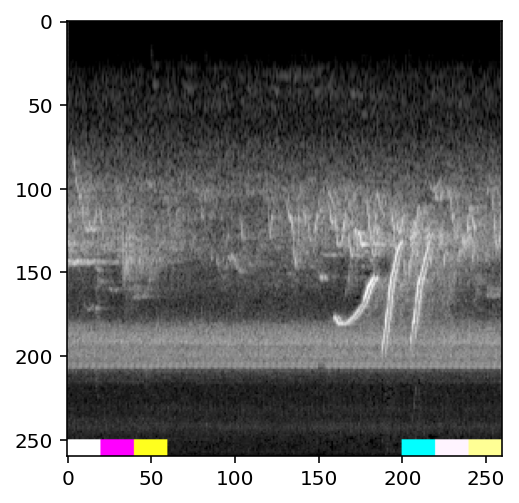

In [47]:
plt.imshow(a[0][0])

# model

In [48]:
def get_model():
    inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model = keras.applications.EfficientNetB2(
        weights="imagenet", include_top=False
    )
    x = base_model(inputs)
    x = keras.layers.GlobalAveragePooling2D(name="avg_pool")(x)
    x = keras.layers.Flatten(name="flatten")(x)
    outputs = keras.layers.Dense(NUM_CLASSES, activation="sigmoid")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        loss="binary_crossentropy",
        optimizer=Adam(lr=0.0005),
        metrics=[
            "acc",
            keras.metrics.Recall(),
            keras.metrics.Precision(),
            tfa.metrics.F1Score(num_classes=NUM_CLASSES, average="micro"),
        ],
    )
    return model


policy = keras.mixed_precision.experimental.Policy("mixed_float16")
keras.mixed_precision.experimental.set_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3090, compute capability 8.6


In [49]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=12,
        restore_best_weights=True,
        verbose=1,
        mode="min",
    ),
    keras.callbacks.ModelCheckpoint(
        "/app/_data/models/Eff2_5/Eff2_5.h5",
        monitor="val_loss",
        verbose=1,
        save_best_only=True,
        save_weights_only=False,
        mode="min",
        save_freq="epoch",
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.9,
        patience=5,
        verbose=1,
        mode="min",
        min_delta=1e-4,
        min_lr=0.00000001,
    ),
    keras.callbacks.TensorBoard(
        log_dir="/app/.tensorboard/Eff2_5/", histogram_freq=0
    ),
    keras.callbacks.experimental.BackupAndRestore(
        "/app/_data/models/Eff2_5/backup/"
    ),
    keras.callbacks.TerminateOnNaN(),
]

In [50]:
model = get_model()
history = model.fit(
    gen_train,
    validation_data=gen_valid,
    epochs=100,
    steps_per_epoch=train.shape[0] // BATCH_SIZE,
    validation_steps=valid.shape[0] // BATCH_SIZE,
    verbose=1,
    workers=20,
    max_queue_size=50,
    callbacks=callbacks,
)

Epoch 5/100
   1/2087 [..............................] - ETA: 10s - loss: 0.0042 - acc: 0.8900 - recall: 0.4853 - precision: 0.9333 - f1_score: 0.7894WARNING:tensorflow:From /usr/local/lib/python3.8/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
2087/2087 [==============================] - ETA: 0s - loss: 0.0046 - acc: 0.8819 - recall: 0.4485 - precision: 0.9552 - f1_score: 0.7737
Epoch 00005: val_loss improved from inf to 0.00408, saving model to /app/_data/models/Eff2_5/Eff2_5.h5
2087/2087 [==============================] - 1782s 854ms/step - loss: 0.0046 - acc: 0.8819 - recall: 0.4485 - precision: 0.9552 - f1_score: 0.7737 - val_loss: 0.0041 - val_acc: 0.9050 - val_recall: 0.4777 - val_precision: 0.9575 - val_f1_score: 0.7918
Epoch 6/100
2087/2087 [==============================] - ETA: 0s - loss: 0.0038